In [1]:
# parameters
DEVICE='cuda'
GPU_DEVICE = 0
MODEL = 'v2cpf'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import torch.distributions as TD
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import random

import sys, os
sys.path.append('..')

# icnns
from ofmsrc.icnn import (
    ICNNCPF,
    ICNN2CPF,
    ICNN3CPF,
    LseICNNCPF,
    ResICNN2CPF,
    DenseICNN2CPF
)
from ofmsrc.icnn import (
    LinActnormICNN,
    DenseICNN
)

from ofmsrc.model_tools import (
    id_pretrain_model,
    ofm_forward,
    ofm_loss
)
from ofmsrc.model_tools import (
    TorchoptimInvParams,
    TorchlbfgsInvParams,
    BruteforceIHVParams
)

from ofmsrc.discrete_ot import OTPlanSampler

# dgm_utils
from ofmsrc.dgm_utils import visualize_2d_samples_groups, visualize_2d_map
from ofmsrc.tools import freeze, unfreeze, EMA

# spiral dataset etc.
from ofmsrc.distributions import Sampler, StandardNormalSampler

torch.cuda.set_device(GPU_DEVICE)

In [4]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    random.seed(seed)

In [5]:
def get_indepedent_plan_sample_fn(sampler_x, sampler_y):
    
    def ret_fn(batch_size):
        x_samples = sampler_x.sample(batch_size)
        y_samples = sampler_y.sample(batch_size)
        return x_samples, y_samples
    
    return ret_fn


def get_discrete_ot_plan_sample_fn(sampler_x, sampler_y, device='cuda'):
    
    ot_plan_sampler = OTPlanSampler('exact')
    
    def ret_fn(batch_size):
        
        x_samples = sampler_x.sample(batch_size).to(device)
        y_samples = sampler_y.sample(batch_size).to(device)
        
        return ot_plan_sampler.sample_plan(x_samples, y_samples)
    
    return ret_fn

def get_discrete_smallbatch_ot_plan_sample_fn(sampler_x, sampler_y, mb_size=64, device='cuda'):
    sample_fn = get_discrete_ot_plan_sample_fn(sampler_x, sampler_y, device)

    def ret_fn(batch_size):
        spls_X = []
        spls_Y = []
        curr_sampled = 0
        while curr_sampled < batch_size:
            _X, _Y = sample_fn(mb_size)
            spls_X.append(_X); spls_Y.append(_Y)
            curr_sampled += mb_size
        X = torch.cat(spls_X); Y = torch.cat(spls_Y)
        return X[:batch_size], Y[:batch_size]

    return ret_fn

### Source and Target distributions

/tmp/ipykernel_6709/2534182524.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


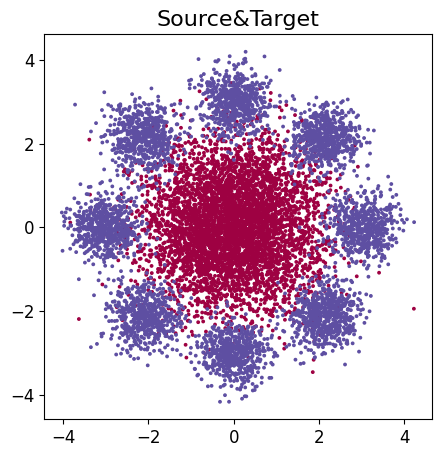

In [6]:
class Mix8GaussiansSampler(Sampler):
    def __init__(
        self, with_central=False, std=1, r=12, dim=2, device='cuda'
    ):
        super().__init__(
            device=device
        )
        assert dim == 2
        self.dim = 2
        self.std, self.r = std, r
        
        self.with_central = with_central
        centers = [
            (1, 0), (-1, 0), (0, 1), (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        if self.with_central:
            centers.append((0, 0))
        self.centers = torch.tensor(
            centers, device=self.device
        )
        
    def sample(self, batch_size=10):
        batch = torch.randn(
            batch_size, self.dim,
            device=self.device
        )
        indices = random.choices(range(len(self.centers)), k=batch_size)
        batch *= self.std
        batch += self.r * self.centers[indices, :]
        return torch.tensor(
            batch, device=self.device
        )

seed_everything()

mix8gau_sampler = Mix8GaussiansSampler(device='cpu', r=3, std=0.4)
standardnormal_sampler = StandardNormalSampler(device='cpu')

source_sampler = standardnormal_sampler
target_sampler = mix8gau_sampler

visualize_2d_samples_groups([
    source_sampler.sample(5024).cpu().numpy(), 
    target_sampler.sample(5024).cpu().numpy()], 'Source&Target', s=3)

In [7]:
sampling_fn = get_discrete_smallbatch_ot_plan_sample_fn(
    source_sampler, 
    target_sampler, mb_size=64, device=DEVICE)

### Model

In [8]:
seed_everything()

sampler = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE), 
    torch.tensor([4., 4.]).to(DEVICE))

def get_model(name):
    assert name in [
        'v2cpf'
    ]
    print(f"Used model: {name}")
    model = ICNN2CPF(dim=2, dimh=1024, num_hidden_layers=2, batch_size=1024).to(DEVICE)
    id_pretrain_model(model, sampler, n_max_iterations=200, lr=1e-2)
    return model


In [10]:
model = get_model(MODEL).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=3e-3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 89.82it/s]

Loss: 0.30949991941452026


Folder to save results

In [11]:
# make directory for saving results
EXP_DIR = f'./gau_{MODEL}_mb64'
if os.path.exists(EXP_DIR):
    pass
    # prevents overwriting old experiment folders by accident
    # raise RuntimeError('Folder "{}" already exists. Please use a different "EXP_DIR".'.format(EXP_DIR))
else:
    os.makedirs(EXP_DIR)

samples_path = os.path.join(EXP_DIR, 'samples.png')
curr_model_path = os.path.join(EXP_DIR, 'model.pth')
loss_path = os.path.join(EXP_DIR, 'loss.png')

### Fitting eight gaussians

In [12]:
MAX_ITER = 30000
BATCH_SIZE = 1024
INV_TOLERANCE = 0.01

In [13]:
ema = EMA(0, betas=[0.999, 0.99])

Iteration 29500

Loss: 1.6849654912948608


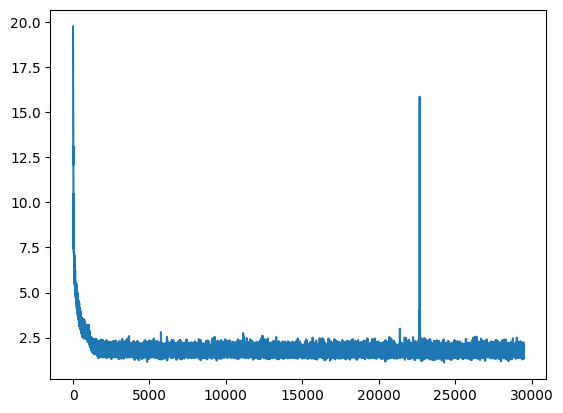

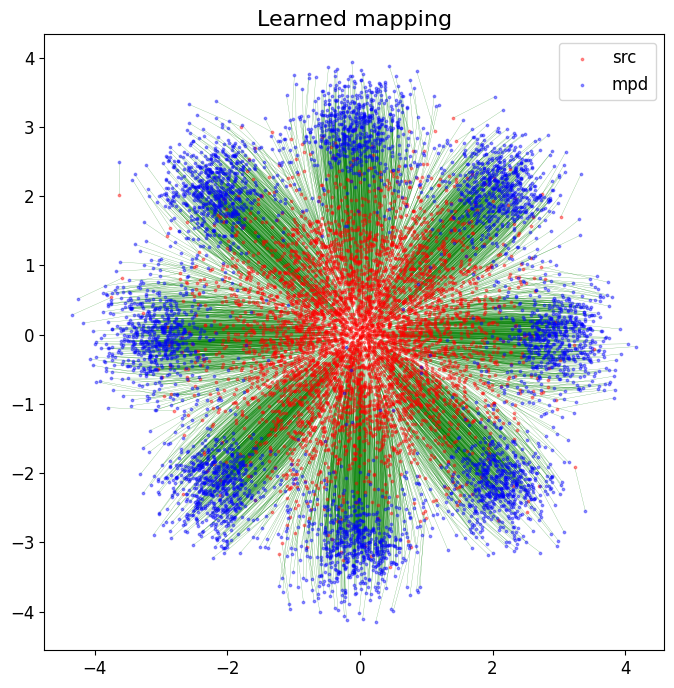

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [1:42:40<00:00,  4.87it/s, loss=-0.208, tloss=1.67]


In [14]:
print('Fitting the Spiral')
loss_history = []

with tqdm(range(0, MAX_ITER)) as tbar:
    for iteration in tbar:
        X, Y = sampling_fn(BATCH_SIZE)
        X = X.to(DEVICE); Y = Y.to(DEVICE)
        t = (torch.rand(BATCH_SIZE) + 1e-8).to(DEVICE)
    
        current_metrics = dict()
        loss, true_loss = ofm_loss(model, X, Y, t,
                   TorchlbfgsInvParams(lbfgs_params=dict(tolerance_grad = INV_TOLERANCE), max_iter=5), 
                   BruteforceIHVParams(), stats=current_metrics)
        
        optim.zero_grad()
        loss.backward()
        optim.step(); model.convexify();
        current_metrics['loss'] = loss.item(); current_metrics['true_loss'] = true_loss.item()

        ema(model)
        
        loss_history.append(true_loss.item())
        tbar.set_postfix(loss=current_metrics['loss'], tloss = current_metrics['true_loss'])
        if iteration % 500 == 0:
            clear_output(wait=True)
            print("Iteration", iteration)
            print(f'\nLoss: {true_loss.item()}')
            plt.plot(loss_history)
            plt.savefig(loss_path)
            plt.show()
            X = source_sampler.sample(5000).to(DEVICE)
            Y = model.push_nograd(X)
            visualize_2d_map(
                X.cpu().numpy(), 
                Y.cpu().numpy(), 
                'Learned mapping', 
                data_label='src', 
                mapped_data_label='mpd', s=3, figsize=(8, 8), save_path=samples_path)
            torch.save(model.state_dict(), curr_model_path)
            for beta in [0.999, 0.99]:
                beta_model_path = os.path.join(EXP_DIR, 'model_{}.pth'.format(beta))
                torch.save(ema.get_model(beta), beta_model_path)

    # if iteration % 5000 == 0:
    #     path = f'./swissroll_model_{10001 + iteration}.pth'
    #     torch.save(model.state_dict(), path)
        